# Параллельные вычисления

__Автор задач: Блохин Н.В. (NVBlokhin@fa.ru)__

Материалы:
* Макрушин С.В. Лекция "Параллельные вычисления"
* https://docs.python.org/3/library/multiprocessing.html
    * https://docs.python.org/3/library/multiprocessing.html#multiprocessing.Process
    * https://docs.python.org/3/library/multiprocessing.html#multiprocessing.pool.Pool
    * https://docs.python.org/3/library/multiprocessing.html#multiprocessing.Queue
* https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html
* https://numpy.org/doc/stable/reference/generated/numpy.array_split.html
* https://nalepae.github.io/pandarallel/
    * https://github.com/nalepae/pandarallel/blob/master/docs/examples_windows.ipynb
    * https://github.com/nalepae/pandarallel/blob/master/docs/examples_mac_linux.ipynb

## Задачи для совместного разбора

In [53]:
!pip install pandarallel

1. Посчитайте, сколько раз встречается буква "a" в файлах ["xaa", "xab", "xac", "xad"]. 

In [54]:
import multiprocessing

files = [f"{name}.txt" for name in ["xaa", "xab", "xac", "xad"]]

In [55]:
from collections import Counter

In [56]:
def count_a(file):
    with open(file, "r", encoding="utf8") as fp:
        text = fp.read().lower()
    res = Counter(text)["a"]
    print(file, res)
    return res

In [57]:
%%time
[count_a(f) for f in files]

xaa.txt 2599627


KeyboardInterrupt: 

In [58]:
%%file count_a.py
from collections import Counter

def count_a(file):
    with open(file, "r", encoding="utf8") as fp:
        text = fp.read().lower()
    res = Counter(text)["a"]
    print(file, res)
    return res


Overwriting count_a.py


In [59]:
from count_a import count_a

In [60]:
%%time
with multiprocessing.Pool(processes=4) as pool:
    res = pool.map(count_a, files)
res

KeyboardInterrupt: 

In [61]:
%%file count_a_q.py
from collections import Counter

def count_a_q(file, queue):
    with open(file, "r", encoding="utf8") as fp:
        text = fp.read().lower()
    res = Counter(text)["a"]
    print(file, res)
    queue.put(res)

Overwriting count_a_q.py


In [62]:
from count_a_q import count_a_q

In [63]:
%%time
processes = []
queue = multiprocessing.Queue()

for f in files:
    process = multiprocessing.Process(target=count_a_q, args=(f, queue))
    processes.append(process)
    process.start()

res = []
while len(res) < 4:
    if not queue.empty():
        res.append(queue.get())
    
for p in processes:
    p.join()
    
# ...
res

Wall time: 4.29 s


[1460452, 2599868, 2599627, 2605911]

2. Выведите на экран слова из файла words_alpha, в которых есть две или более буквы "e" подряд.

In [64]:
import pandas as pd

words = (
    pd.read_csv("words_alpha.txt", header=None)[0]
    .dropna()
    .sample(frac=1, replace=True)
)

In [65]:
import re

def f(s):
    return bool(re.findall(r"e{2,}", s))

In [66]:

%%time
words[words.map(f)]

Wall time: 968 ms


247337    preerection
95907         eellike
256114       pugarees
264621       reeledid
95930          eerock
             ...     
265799      regreeted
143440        honoree
118674      freewheel
30312         beefily
160082         jageer
Name: 0, Length: 7091, dtype: object

In [67]:
from pandarallel import pandarallel
pandarallel.initialize()

INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


In [68]:
%%file for_map.py
import re

def f(s):
    return bool(re.findall(r"e{2,}", s))

Overwriting for_map.py


In [69]:
from for_map import f

In [ ]:
%%time
words[words.parallel_map(f)]

In [ ]:
import re

## Лабораторная работа 10

__При решении данных задач не подразумевается использования циклов или генераторов Python в ходе работы с пакетами `numpy` и `pandas`, если в задании не сказано обратного. Решения задач, в которых для обработки массивов `numpy` или структур `pandas` используются явные циклы (без согласования с преподавателем), могут быть признаны некорректными и не засчитаны.__

In [33]:
import multiprocessing
import pandas as pd
import re
import numpy as np

1\. В каждой строке файла `tag_nsteps.csv` хранится информация о тэге рецепта и количестве шагов в этом рецепте в следующем виде:

```
tags,n_steps
hungarian,2
european,6
occasion,4
pumpkin,4
................
```

Всего в исходном файле хранится чуть меньше, чем 71 млн, строк. Разбейте файл `tag_nsteps.csv` на несколько (например, 8) примерно одинаковых по объему файлов c названиями `tag_nsteps_*.csv`, где вместо символа `*` указан номер очередного файла. Каждый файл имеет структуру, аналогичную оригинальному файлу (включая заголовок).

__Важно__: здесь и далее вы не можете загружать в память весь исходный файл сразу. 

In [34]:
for index, chunk in enumerate(pd.read_csv('tag_nsteps.csv', chunksize=71000000//8)):
    chunk.to_csv(f'tag_nsteps_{index+1}.csv', index=False)

2\. Напишите функцию, которая принимает на вход название файла, созданного в результате решения задачи 1, считает для каждого тэга сумму по столбцу `n_steps` и количество строк c этим тэгом, и возвращает результат в виде словаря. Ожидаемый вид итогового словаря:

```
{
    '1-day-or-more': {'sum': 56616, 'count': 12752},
    '15-minutes-or-less': {'sum': 195413, 'count': 38898},
    '3-steps-or-less': {'sum': 187938, 'count': 39711},
    ....
}
```

Примените данную функцию к каждому файлу, полученному в задании 1, и соберите результат в виде списка словарей. Не используйте параллельных вычислений. 

Выведите на экран значение по ключу "30-minutes-or-less" для каждого из словарей.

In [35]:
def get_tag_sum_count_from_file(file: str) -> dict:
    dict_tags = {}
    df = pd.read_csv(file)
    df_grouped = df.groupby('tags').sum('n_steps')
    df_grouped['count'] = df.groupby('tags').count()
    df_grouped.columns = ['sum', 'count']
    return df_grouped.to_dict(orient='index')

In [36]:
files = [f"tag_nsteps_{index}.csv" for index in np.arange(1,9)]

In [37]:
tag_sum_list = [get_tag_sum_count_from_file(f) for f in files]

In [38]:
list(map(lambda x: x['30-minutes-or-less'], tag_sum_list))

[{'sum': 348943, 'count': 45605},
 {'sum': 350194, 'count': 46053},
 {'sum': 353624, 'count': 46295},
 {'sum': 347697, 'count': 45621},
 {'sum': 346528, 'count': 45650},
 {'sum': 350333, 'count': 46014},
 {'sum': 346536, 'count': 45814},
 {'sum': 339350, 'count': 44730}]

3\. Напишите функцию, которая объединяет результаты обработки отдельных файлов. Данная функция принимает на вход список словарей, каждый из которых является результатом вызова функции `get_tag_sum_count_from_file` для конкретного файла, и агрегирует эти словари. Не используйте параллельных вычислений.

Процедура агрегации словарей имеет следующий вид:
$$d_{agg}[k] = \{sum: \sum_{i=1}^{n}d_{i}[k][sum], count: \sum_{i=1}^{n}d_{i}[k][count]\}$$
где $d_1, d_2, ..., d_n$- результат вызова функции `get_tag_sum_count_from_file` для конкретных файлов.

Примените данную функцию к результату выполнения задания 2. Выведите на экран результат для тэга "30-minutes-or-less".

In [39]:
def agg_results(tag_sum_count_list: list) -> dict:
    result = {}
    for part in tag_sum_count_list:
        for tag in part:
            if tag in result:
                result[tag]['sum'] += part[tag]['sum']
                result[tag]['count'] += part[tag]['count']
            else:
                result[tag] = {'sum': part[tag]['sum'], 'count': part[tag]['count']}
    return result

In [40]:
agg_results(tag_sum_list)['30-minutes-or-less']

{'sum': 2783205, 'count': 365782}

In [41]:
tag_sum_count_dict = agg_results(tag_sum_list)

4\. Напишите функцию, которая считает среднее значение количества шагов для каждого тэга в словаре, имеющего вид, аналогичный словарям в задаче 2, и возвращает результат в виде словаря . Используйте решения задач 1-3, чтобы получить среднее значение количества шагов каждого тэга для всего датасета, имея результаты обработки частей датасета и результат их агрегации. Выведите на экран результат для тэга "30-minutes-or-less".

Определите, за какое время задача решается для всего датасета. При замере времени учитывайте время расчета статистики для каждого файла, агрегации результатов и, собственно, вычисления средного. Временем, затрачиваемым на процедуру разбиения исходного файла можно пренебречь.

In [42]:
def get_tag_mean_n_steps(tag_sum_count: dict) -> dict:
    result = {}
    for tag in tag_sum_count:
        result[tag] = tag_sum_count[tag]['sum']/tag_sum_count[tag]['count']
    return result

In [43]:
get_tag_mean_n_steps(tag_sum_count_dict)["30-minutes-or-less"]

7.608917333275011

In [44]:
%%time
def get_tag_sum_count_from_file(file: str) -> dict:
    dict_tags = {}
    df = pd.read_csv(file)
    df_grouped = df.groupby('tags').sum('n_steps')
    df_grouped['count'] = df.groupby('tags').count()
    df_grouped.columns = ['sum', 'count']
    return df_grouped.to_dict(orient='index')

files = [f"tag_nsteps_{index}.csv" for index in np.arange(1,9)]
tag_sum_list = [get_tag_sum_count_from_file(f) for f in files]

def agg_results(tag_sum_count_list: list) -> dict:
    result = {}
    for part in tag_sum_count_list:
        for tag in part:
            if tag in result:
                result[tag]['sum'] += part[tag]['sum']
                result[tag]['count'] += part[tag]['count']
            else:
                result[tag] = {'sum': part[tag]['sum'], 'count': part[tag]['count']}
    return result

tag_sum_count_dict = agg_results(tag_sum_list)

def get_tag_mean_n_steps(tag_sum_count: dict) -> dict:
    result = {}
    for tag in tag_sum_count:
        result[tag] = tag_sum_count[tag]['sum']/tag_sum_count[tag]['count']
    return result

get_tag_mean_n_steps(tag_sum_count_dict)["30-minutes-or-less"]

Wall time: 1min 7s


7.608917333275011

5\. Повторите решение задачи 4, распараллелив вызовы функции `get_tag_sum_count_from_file` для различных файлов с помощью `multiprocessing.Pool`. Для обработки каждого файла создайте свой собственный процесс. Выведите на экран результат для тэга "30-minutes-or-less". Определите, за какое время задача решается для всех файлов. При замере времени учитывайте время расчета статистики для каждого файла, агрегации результатов и, собственно, вычисления средного. Временем, затрачиваемым на процедуру разбиения исходного файла можно пренебречь.

In [45]:
%%file get_tag_sum_count_from_file.py
import pandas as pd

def get_tag_sum_count_from_file(file: str) -> dict:
    dict_tags = {}
    df = pd.read_csv(file)
    df_grouped = df.groupby('tags').sum('n_steps')
    df_grouped['count'] = df.groupby('tags').count()
    df_grouped.columns = ['sum', 'count']
    return df_grouped.to_dict(orient='index')

Overwriting get_tag_sum_count_from_file.py


In [46]:
from get_tag_sum_count_from_file import get_tag_sum_count_from_file

In [47]:
%%time

files = [f"tag_nsteps_{index}.csv" for index in np.arange(1,9)]

with multiprocessing.Pool(processes=8) as pool:
    res = pool.map(get_tag_sum_count_from_file, files)

def agg_results(tag_sum_count_list: list) -> dict:
    result = {}
    for part in tag_sum_count_list:
        for tag in part:
            if tag in result:
                result[tag]['sum'] += part[tag]['sum']
                result[tag]['count'] += part[tag]['count']
            else:
                result[tag] = {'sum': part[tag]['sum'], 'count': part[tag]['count']}
    return result

tag_sum_count_dict = agg_results(res)

def get_tag_mean_n_steps(tag_sum_count: dict) -> dict:
    result = {}
    for tag in tag_sum_count:
        result[tag] = tag_sum_count[tag]['sum']/tag_sum_count[tag]['count']
    return result

get_tag_mean_n_steps(tag_sum_count_dict)["30-minutes-or-less"]

Wall time: 15.2 s


7.608917333275011

6\. Повторите решение задачи 4, распараллелив вычисления функции `get_tag_sum_count_from_file` для различных файлов с помощью `multiprocessing.Process`. Для обработки каждого файла создайте свой собственный процесс. Для обмена данными между процессами используйте `multiprocessing.Queue`.

Выведите на экран результат для тэга "30-minutes-or-less". Определите, за какое время задача решается для всех файлов. При замере времени учитывайте время расчета статистики для каждого файла, агрегации результатов и, собственно, вычисления средного. Временем, затрачиваемым на процедуру разбиения исходного файла можно пренебречь.

In [48]:
%%file get_tag_sum_count_from_file.py
import pandas as pd

def get_tag_sum_count_from_file(file: str, queue) -> dict:
    dict_tags = {}
    df = pd.read_csv(file)
    df_grouped = df.groupby('tags').sum('n_steps')
    df_grouped['count'] = df.groupby('tags').count()
    df_grouped.columns = ['sum', 'count']
    queue.put(df_grouped.to_dict(orient='index'))

Overwriting get_tag_sum_count_from_file.py


In [49]:
from get_tag_sum_count_from_file import get_tag_sum_count_from_file

In [50]:
%%time
files = [f"tag_nsteps_{index}.csv" for index in np.arange(1,9)]

processes = []
queue = multiprocessing.Queue()

for f in files:
    process = multiprocessing.Process(target=get_tag_sum_count_from_file, args=(f, queue))
    processes.append(process)
    process.start()

res = []
while len(res) < 8:
    if not queue.empty():
        res.append(queue.get())
    
for p in processes:
    p.join()
    
def agg_results(tag_sum_count_list: list) -> dict:
    result = {}
    for part in tag_sum_count_list:
        for tag in part:
            if tag in result:
                result[tag]['sum'] += part[tag]['sum']
                result[tag]['count'] += part[tag]['count']
            else:
                result[tag] = {'sum': part[tag]['sum'], 'count': part[tag]['count']}
    return result

tag_sum_count_dict = agg_results(res)

def get_tag_mean_n_steps(tag_sum_count: dict) -> dict:
    result = {}
    for tag in tag_sum_count:
        result[tag] = tag_sum_count[tag]['sum']/tag_sum_count[tag]['count']
    return result

get_tag_mean_n_steps(tag_sum_count_dict)["30-minutes-or-less"]

Wall time: 19 s


7.608917333275011

7\. Исследуйте, как влияет количество запущенных одновременно процессов на скорость решения задачи. Узнайте количество ядер вашего процессора $K$. Повторите решение задачи 1, разбив исходный файл на $\frac{K}{2}$, $K$ и $2K$ фрагментов. Для каждого из разбиений повторите решение задачи 5. Визуализируйте зависимость времени выполнения кода от количества файлов в разбиении. Сделайте вывод в виде текстового комментария.

In [51]:
for index, chunk in enumerate(pd.read_csv('tag_nsteps.csv', chunksize=71000000//3)):
    chunk.to_csv(f'tag_nsteps_{index+1}.csv', index=False)

In [52]:
%%file get_tag_sum_count_from_file.py
import pandas as pd

def get_tag_sum_count_from_file(file: str) -> dict:
    dict_tags = {}
    df = pd.read_csv(file)
    df_grouped = df.groupby('tags').sum('n_steps')
    df_grouped['count'] = df.groupby('tags').count()
    df_grouped.columns = ['sum', 'count']
    return df_grouped.to_dict(orient='index')

Overwriting get_tag_sum_count_from_file.py


In [53]:
from get_tag_sum_count_from_file import get_tag_sum_count_from_file

In [54]:
%%timeit -n1 -r1 -o

files = [f"tag_nsteps_{index}.csv" for index in np.arange(1,4)]

with multiprocessing.Pool(processes=3) as pool:
    res = pool.map(get_tag_sum_count_from_file, files)

def agg_results(tag_sum_count_list: list) -> dict:
    result = {}
    for part in tag_sum_count_list:
        for tag in part:
            if tag in result:
                result[tag]['sum'] += part[tag]['sum']
                result[tag]['count'] += part[tag]['count']
            else:
                result[tag] = {'sum': part[tag]['sum'], 'count': part[tag]['count']}
    return result

tag_sum_count_dict = agg_results(res)

def get_tag_mean_n_steps(tag_sum_count: dict) -> dict:
    result = {}
    for tag in tag_sum_count:
        result[tag] = tag_sum_count[tag]['sum']/tag_sum_count[tag]['count']
    return result

print(get_tag_mean_n_steps(tag_sum_count_dict)["30-minutes-or-less"])

7.608917333275011
23.4 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


<TimeitResult : 23.4 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)>

In [55]:
timek0 = _.average
timek0

23.374589499999956

In [56]:
for index, chunk in enumerate(pd.read_csv('tag_nsteps.csv', chunksize=71000000//6)):
    chunk.to_csv(f'tag_nsteps_{index+1}.csv', index=False)

In [57]:
%%file get_tag_sum_count_from_file.py
import pandas as pd

def get_tag_sum_count_from_file(file: str) -> dict:
    dict_tags = {}
    df = pd.read_csv(file)
    df_grouped = df.groupby('tags').sum('n_steps')
    df_grouped['count'] = df.groupby('tags').count()
    df_grouped.columns = ['sum', 'count']
    return df_grouped.to_dict(orient='index')

Overwriting get_tag_sum_count_from_file.py


In [58]:
from get_tag_sum_count_from_file import get_tag_sum_count_from_file

In [59]:
%%timeit -n1 -r1 -o

files = [f"tag_nsteps_{index}.csv" for index in np.arange(1,7)]

with multiprocessing.Pool(processes=6) as pool:
    res = pool.map(get_tag_sum_count_from_file, files)

def agg_results(tag_sum_count_list: list) -> dict:
    result = {}
    for part in tag_sum_count_list:
        for tag in part:
            if tag in result:
                result[tag]['sum'] += part[tag]['sum']
                result[tag]['count'] += part[tag]['count']
            else:
                result[tag] = {'sum': part[tag]['sum'], 'count': part[tag]['count']}
    return result

tag_sum_count_dict = agg_results(res)

def get_tag_mean_n_steps(tag_sum_count: dict) -> dict:
    result = {}
    for tag in tag_sum_count:
        result[tag] = tag_sum_count[tag]['sum']/tag_sum_count[tag]['count']
    return result

print(get_tag_mean_n_steps(tag_sum_count_dict)["30-minutes-or-less"])

7.608917333275011
14.7 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


<TimeitResult : 14.7 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)>

In [60]:
timek = _.average
timek

14.748135999999931

In [61]:
for index, chunk in enumerate(pd.read_csv('tag_nsteps.csv', chunksize=71000000//12)):
    chunk.to_csv(f'tag_nsteps_{index+1}.csv', index=False)

In [62]:
%%file get_tag_sum_count_from_file.py
import pandas as pd

def get_tag_sum_count_from_file(file: str) -> dict:
    dict_tags = {}
    df = pd.read_csv(file)
    df_grouped = df.groupby('tags').sum('n_steps')
    df_grouped['count'] = df.groupby('tags').count()
    df_grouped.columns = ['sum', 'count']
    return df_grouped.to_dict(orient='index')

Overwriting get_tag_sum_count_from_file.py


In [63]:
from get_tag_sum_count_from_file import get_tag_sum_count_from_file

In [64]:
%%timeit -n1 -r1 -o

files = [f"tag_nsteps_{index}.csv" for index in np.arange(1,13)]

with multiprocessing.Pool(processes=12) as pool:
    res = pool.map(get_tag_sum_count_from_file, files)

def agg_results(tag_sum_count_list: list) -> dict:
    result = {}
    for part in tag_sum_count_list:
        for tag in part:
            if tag in result:
                result[tag]['sum'] += part[tag]['sum']
                result[tag]['count'] += part[tag]['count']
            else:
                result[tag] = {'sum': part[tag]['sum'], 'count': part[tag]['count']}
    return result

tag_sum_count_dict = agg_results(res)

def get_tag_mean_n_steps(tag_sum_count: dict) -> dict:
    result = {}
    for tag in tag_sum_count:
        result[tag] = tag_sum_count[tag]['sum']/tag_sum_count[tag]['count']
    return result

print(get_tag_mean_n_steps(tag_sum_count_dict)["30-minutes-or-less"])

7.608917333275011
18.3 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


<TimeitResult : 18.3 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)>

In [65]:
time2k = _.average
time2k

18.266986999999972

In [66]:
import matplotlib.pyplot as plt

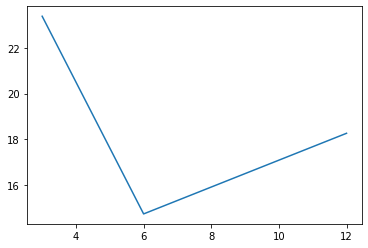

In [67]:
x = [3, 6, 12]
y = [timek0, timek, time2k]
fig, ax = plt.subplots(1,1)
ax.plot(x, y)

In [68]:
#Время выполнения самое быстрое при количестве процессов, равном количестве ядер. 
#Далее, при возрастании количества процессов больше времени тратится на распараллеливание процессов.

8\. Напишите функцию `parallel_map`, которая принимает на вход серию `s` `pd.Series` и функцию одного аргумента `f` и поэлементно применяет эту функцию к серии, распараллелив вычисления при помощи пакета `multiprocessing`. Логика работы функции `parallel_map` должна включать следующие действия:
* разбиение исходной серии на $K$ частей, где $K$ - количество ядер вашего процессора;
* параллельное применение функции `f` к каждой части при помощи метода _серии_ `map` при помощи нескольких подпроцессов;
* объединение результатов работы подпроцессов в одну серию. 

In [69]:
def call_function(s: pd.Series):
    return s.map(f)

In [70]:
def parallel_map(s: pd.Series, f: callable) -> pd.Series:
    arr_split = np.array_split(s, 6)
    with multiprocessing.Pool(processes=6) as pool:
        res = pool.map(f, arr_split)
    return pd.concat(res)

In [71]:
#Функция для использования метода серий map отдельно, а parallel_map нужно вызывать с параметрами (s, call_function),
#потому что нельзя использовать лямбда функции внутри вызова multiprocessing map, о чем говорит вызов функции ниже

In [72]:
#arr_split = np.array_split(df['tags'][~df['tags'].isna()], 8)
#with multiprocessing.Pool(processes=6) as pool:
#    res = pool.map(lambda x: x.map(f), arr_split)
#pd.concat(res)

9\. Напишите функцию `f`, которая принимает на вход тэг и проверяет, удовлетворяет ли тэг следующему шаблону: `[любое число]-[любое слово]-or-less`. Возьмите любой фрагмент файла, полученный в задании 1, примените функцию `f` при помощи `parallel_map` к столбцу `tags` и посчитайте количество тэгов, подходящих под этот шаблон. Решите ту же задачу, воспользовавшись методом _серий_ `map`. Сравните время и результат выполнения двух решений.

In [73]:
df = pd.read_csv('tag_nsteps_1.csv')

In [74]:
%%file for_map.py
import re

def f(tag: str) -> bool:
    patt = re.compile(r"\d+-[a-zA-Z]+'?[a-zA-Z]*-or-less", re.I)
    return bool(re.fullmatch(patt, tag))

Overwriting for_map.py


In [75]:
from for_map import f

In [76]:
%%file call_function.py
import pandas as pd
import re
from for_map import f

def call_function(s: pd.Series):
    return s.map(f)

Overwriting call_function.py


In [77]:
from call_function import call_function

In [78]:
%%time
parallel_map(df['tags'][~df['tags'].isna()], call_function).sum()

Wall time: 9.73 s


170603

In [79]:
%%time
df['tags'][~df['tags'].isna()].map(f).sum()

Wall time: 34.9 s


170603

In [80]:
#Результат выполнения идентичный, но время выполнения написанной вручную функции parallel_map в три раза быстрее

10\. Используя пакет `pandarallel`, примените функцию `f` из задания 9 к столбцу `tags` таблицы, с которой вы работали этом задании. Посчитайте количество тэгов, подходящих под описанный шаблон. Измерьте время выполнения кода. Выведите на экран полученный результат.

In [81]:
from pandarallel import pandarallel
pandarallel.initialize()

INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


In [82]:
from for_map import f

In [83]:
%%time
df['tags'][~df['tags'].isna()].parallel_map(f).sum()

Wall time: 13.4 s


170603